In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import os

plt.rcParams["font.family"] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['CMU Sans Serif']
plt.rcParams['mathtext.default'] = 'regular'
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)

SMALL_SIZE = 12
MEDIUM_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
scan_file = '../data/test_simulations_b/test_simulation_{:d}_out/test_simulation_{:d}'
min_file = '../data/test_simulations_b/test_simulation_{:d}_out/test_simulation_{:d}_f_b012345678.csv'

infile_dat = '../data/test_simulations_b/test_simulation_{:d}.csv'
prediction_file =   '../data/test_simulations_b/test_simulation_{:d}_out/test_simulation_{:d}_prediction.csv'
prediction_file_b = '../data/test_simulations_b/test_simulation_{:d}_out/test_simulation_{:d}_prediction_backward.csv'
prediction_file_f = '../data/test_simulations_b/test_simulation_{:d}_out/test_simulation_{:d}_prediction_forward.csv'
prediction_file_no_min =  '../data/test_simulations_b/test_simulation_{:d}_no_min/test_simulation_{:d}_prediction.csv'

# 1. Parameter scans



In [3]:
def read_params_config(filename):
    df = pd.read_csv(filename, nrows=11)
    return df

def get_params_config(df, param):
    return df.loc[df['name'] == param]

def get_scan_file(search_dir):
    all_files = os.listdir(search_dir) 
    files = []
    for file in all_files:
        if "scan_" in file and ".csv" in file:
            files.append(os.path.join(search_dir ,file))
    return files

def get_scan_file_prefix(prefix):
    suffix_ordered =["_scan_mean_lambda.csv",
                    "_scan_gamma_lambda.csv",
                    "_scan_var_lambda.csv",
                    "_scan_mean_q.csv",
                    "_scan_gamma_q.csv",
                    "_scan_var_q.csv",
                    "_scan_beta.csv",
                    "_scan_var_x.csv",
                    "_scan_var_g.csv",
                    "_scan_var_dx.csv",
                    "_scan_var_dg.csv"]
    files = []
    for suffix in suffix_ordered:
        file = prefix + suffix
        if os.path.isfile(file):   
            files.append(file)
    return files


In [4]:
def read_1dscan(filename):
    tag = "scan_"
    base = filename.split("/")[-1]
    parameter = base[base.find(tag)+len(tag):-4]

    df = pd.read_csv(filename, skiprows=14)    
    return df[[parameter, 'likelihood']], parameter


def plot_1dscans(filenames, cols=3, width=14):
    rows = np.ceil(len(filenames)/cols).astype(int)
    fig, axes = plt.subplots(rows, cols, figsize=(width,0.7*width/cols*rows))
    # fig = plt.figure()
    for i, ax in enumerate(axes.ravel()):
        if i<len(filenames):
            scan, parameter = read_1dscan(filenames[i])

            param_range = scan.to_numpy()[:,0]
            ll = scan.to_numpy()[:,1]

            ax.plot(param_range,ll, label='scan')

            params_config = read_params_config(filenames[i])
            init = get_params_config(params_config, parameter)["init"].values[0]
            init_idx = np.searchsorted(param_range, init)
            ax.axvline(x=init, label='simulation value', ls='--', color='tab:orange')
            ax.axhline(y=ll[init_idx], ls='--', color='tab:orange')

            x_scan_max, y_scan_max = param_range[np.nanargmax(ll)], np.nanmax(ll)

            ax.axvline(x=x_scan_max, label='ll max', ls='--', color='tab:green')
            ax.axhline(y=y_scan_max, ls='--', color='tab:green')


            ax.set_xlabel(parameter)
            ax.set_ylabel('log likelihood')
            ax.ticklabel_format(style='sci', scilimits=(0,1), useOffset=False)
            ax.legend()

        else:
            plt.delaxes(ax)

    plt.tight_layout()
    plot_file = "/".join(filenames[0].split("/")[:-1]) + '/1dscans.pdf'
    plt.savefig(plot_file)
    plt.show()



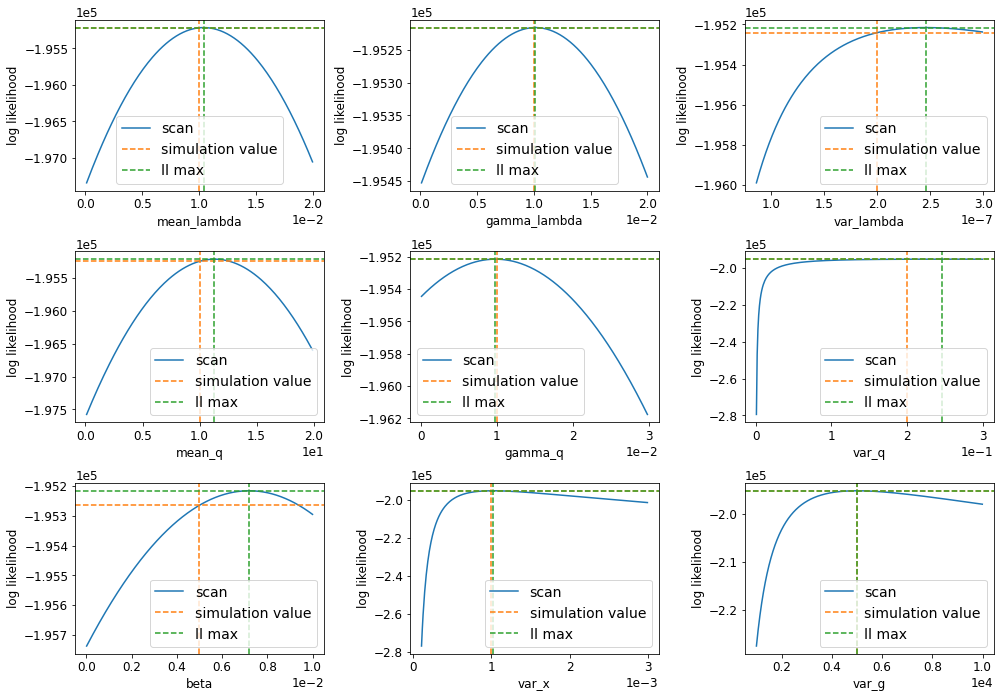

In [5]:
sim_num = 1
scan_prefix = scan_file.format(sim_num, sim_num)
scan_files = get_scan_file_prefix(scan_prefix)
plot_1dscans(scan_files, cols=3)


# 2. Minimization

In [6]:

def read_iteration_process(filename):
    df = pd.read_csv(filename, skiprows=14)    
    return df[["iteration", 'likelihood']]

def plot_minimization(filename):
    mini_data = read_iteration_process(filename)
    fig, ax = plt.subplots(figsize=(5,3))
    iterations = mini_data.to_numpy()[:,0].astype(int)
    ll = mini_data.to_numpy()[:,1]
    ax.plot(iterations, ll)
    ax.scatter(iterations[-1], ll[-1], label="iteration: {:d}, log likelihood: {:.2f}".format(iterations[-1], ll[-1]))
    ax.legend()
    ax.set_xlabel("iterations")
    ax.set_ylabel("log likelihood")
    plt.show()



## Iterations 

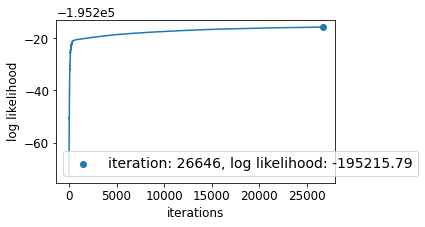

In [7]:
minimization_file =  min_file.format(sim_num, sim_num)

plot_minimization(minimization_file)


## Parameter estimation

In [8]:
def read_minimization(filename, last_n=None):
    df = pd.read_csv(filename, skiprows=14)    
    if last_n != None:
        return df.iloc[[-last_n]]
    return df

def compare_init_final(filename):
    init = read_params_config(filename)[["name", "init"]]
    init=init.set_index("name")

    minimized = read_minimization(filename, 1).transpose()
    reldev = [(init.loc[key].values[0]-minimized.loc[key].values[0])/init.loc[key].values[0] if init.loc[key].values[0]!=0 else None for key in init.index]

    # Table
    comparison = pd.DataFrame({'parameter': init.index, 
                                'simulation': [init.loc[key].values[0] for key in init.index],
                                'minimization': [minimized.loc[key].values[0] for key in init.index],
                                'relative deviation': reldev})


    # plot
    colors = ['tab:orange' if key.startswith('var') else 'tab:blue' for key in init.index]
    fig, ax = plt.subplots(figsize=(10,7))
    plt.title(r"Relative deviation to simulation parameter $(\Theta_i - \Theta_{i, opt})/\Theta_i $")

    x = [xi for xi, ri in zip(np.arange(len(reldev)), reldev) if ri != None]
    reldev = [ri for ri in reldev if ri != None]
    ax.bar(x, reldev, color=colors)

    for i, r in enumerate(reldev):
        if r<0:
            ax.text(x[i] -0.3, r -0.03 , "{:.3f}".format(r), va='center')
        else:
            ax.text(x[i] -0.3, r +0.03 , "{:.3f}".format(r), va='center')


    plt.xticks(np.arange(len(reldev)), init.index[x], rotation=45)
    custom_legend = [Patch(facecolor='tab:orange', label='variances'),
                    Patch(facecolor='tab:blue', label='others')]
    ax.legend(handles=custom_legend, bbox_to_anchor=(1,1), loc="upper left")
    ax.set_ylim([np.min(reldev)-0.1, np.max(reldev) +0.1 ])

    plt.tight_layout()

    plot_file = "/".join(filename.split("/")[:-1]) + '/estim_params.pdf'
    plt.savefig(plot_file)

    plt.show()
    return comparison


## Parameters determined by minimization vs given parameters

../data/test_simulations_b/test_simulation_1_out/test_simulation_1_f_b012345678.csv


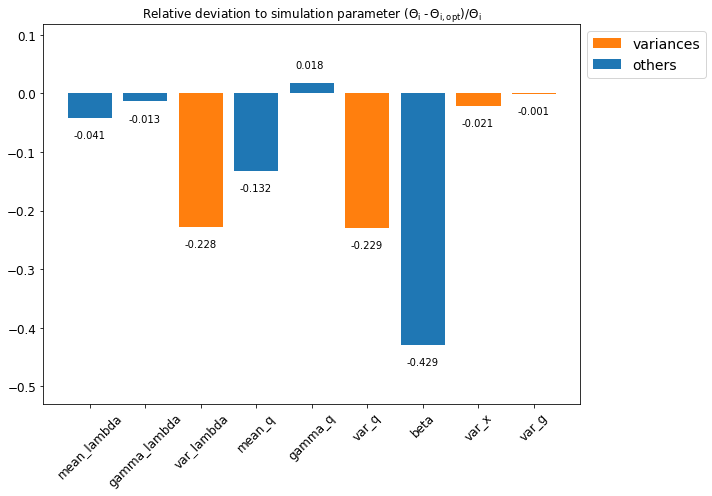

../data/test_simulations_b/test_simulation_2_out/test_simulation_2_f_b012345678.csv


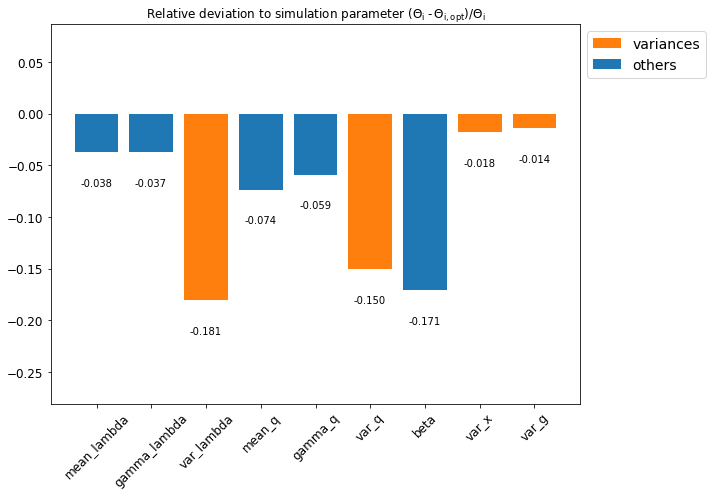

In [10]:
for sim_num in [1,2]:
    minimization_file =  min_file.format(sim_num, sim_num)
    print(minimization_file)

    c_tab = compare_init_final(minimization_file)

# 3. Time series and predictions

In [11]:
sim_num=2

data_dat = pd.read_csv(infile_dat.format(sim_num, sim_num))

data_prediction = pd.read_csv(prediction_file.format(sim_num, sim_num), skiprows=13)
data_backward = pd.read_csv(prediction_file_b.format(sim_num, sim_num), skiprows=13)
data_forward = pd.read_csv(prediction_file_f.format(sim_num, sim_num), skiprows=13)

data_prediction_no_min = pd.read_csv(prediction_file_no_min.format(sim_num, sim_num), skiprows=13)


In [12]:
def plot_time_series(data, cols, title=None, n0=0, n=200):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(10,7))
    ax2 = ax.twinx()
    if title !=None:
        plt.title(title)
    time = data['time_min'][n0:n]
    plots = []
    for i, col in enumerate(cols):
        if i%2==0:
            axes = ax
        else:
           axes = ax2
        d = data[col][n0:n]
        plots.append(axes.plot(time, d, 'o', c=cmap(i), label=col)[0])
        axes.plot(time, d, '-', c=cmap(i))
        axes.set_ylabel(col)

    ax.set_xlabel('time (min)')
    ax.legend(plots, [l.get_label() for l in plots])
    plt.show()


def compare_time_series(data, cols, data2, cols2, data_slice, title=None):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(15,7))

    if title !=None:
        plt.title(title)

    time = data['time_min'][data_slice]
    plots = []

    for i, col in enumerate(cols):
        d = data[col][data_slice]
        plots.append(ax.plot(time, d, 'o', c=cmap(i), label=col)[0])

    for i, col in enumerate(cols2):
        d = data2[col][data_slice]
        plots.append(ax.plot(time, d, '-', c=cmap(i), label=col)[0])

    ax.set_xlabel('time (min)')
    ax.legend(plots, [l.get_label() for l in plots])
    plt.show()


def compare_predictios(predictions, labels, col, data, data_col, data_slice, title=None, ratio=None):
    cmap = plt.cm.tab10
    fig, ax = plt.subplots(figsize=(15,7))
    plots = []

    if title !=None:
        plt.title(title)
        ax.set_ylabel(title)

    time = data['time_min'][data_slice]

    for i, p in enumerate(predictions):
        if i == 0:
            ls = '-'
        else:
            ls ='--'
        plots.append(ax.plot(time, p[col][data_slice], ls, c=cmap(i), label=labels[i])[0])
    ax.set_xlabel("time")

    plots.append(ax.plot(time, data[data_col][data_slice], 'o', c=cmap(0), label="data")[0])

    if ratio!=None:
        ax2 = ax.twinx()
        plots.append(ax2.plot(time, 
                    predictions[ratio[0]][col][data_slice]/predictions[ratio[1]][col][data_slice],
                    color='grey', label='ratio')[0])
        ax2.axhline(y=1, ls='--', color='grey')
        ax2.set_ylabel("ratio")

    ax.legend(plots, [l.get_label() for l in plots])
    plt.show()




## Compared to data without noise

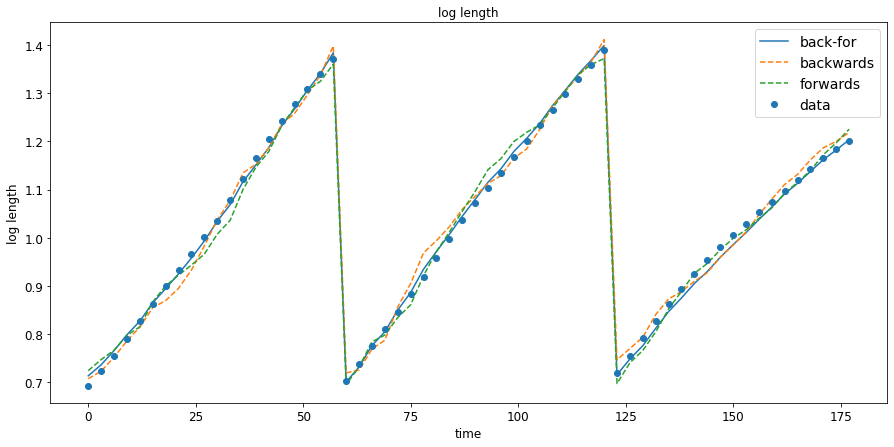

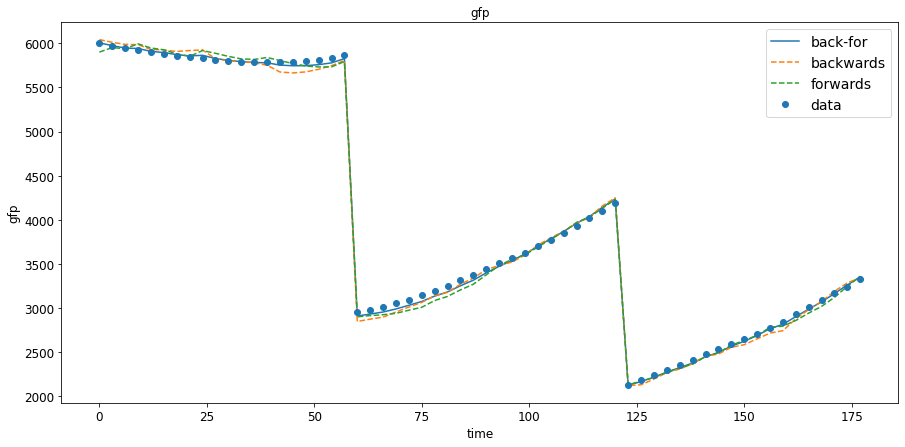

In [13]:
data_slice = slice(0,60)
compare_predictios([data_prediction, data_backward, data_forward], ['back-for', 'backwards', 'forwards'], 'mean_x', data_dat, 'log_leng_no_noise',data_slice, "log length")
compare_predictios([data_prediction, data_backward, data_forward], ['back-for', 'backwards', 'forwards'],'mean_g', data_dat, 'gfp_no_noise',data_slice, "gfp")

## ... with noise

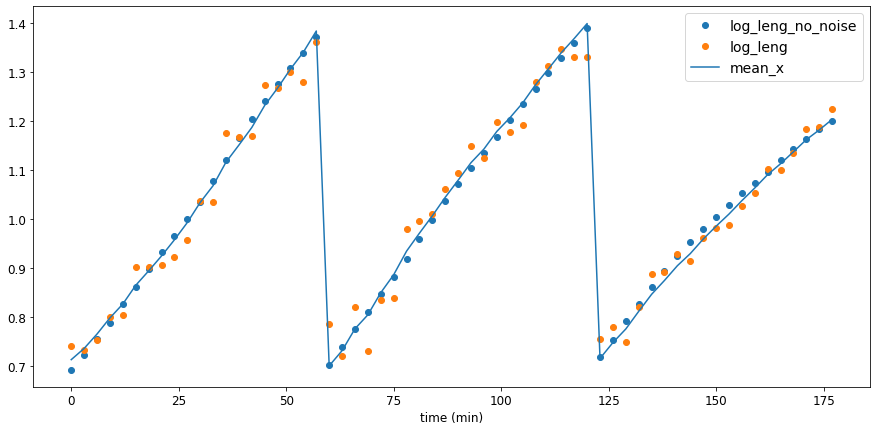

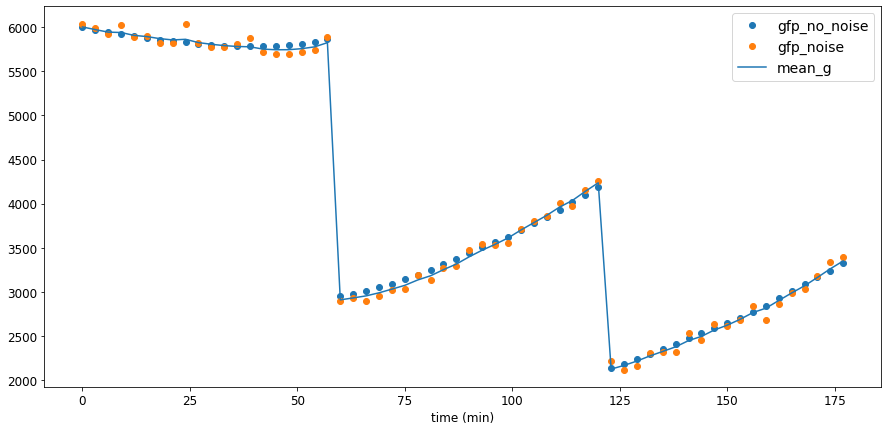

In [14]:

compare_time_series(data_dat, ['log_leng_no_noise','log_leng'], data_prediction, ['mean_x'], data_slice)
compare_time_series(data_dat, ['gfp_no_noise','gfp_noise'], data_prediction, ['mean_g'], data_slice)


## Estimated parameters vs "true" parameters

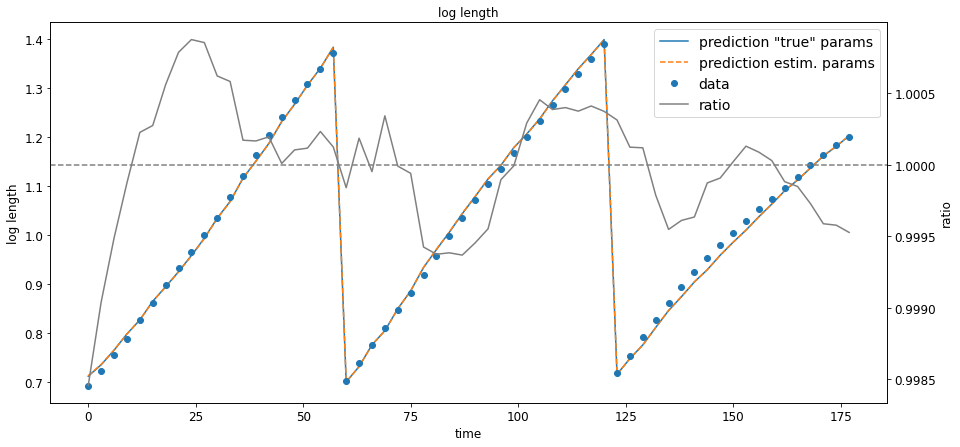

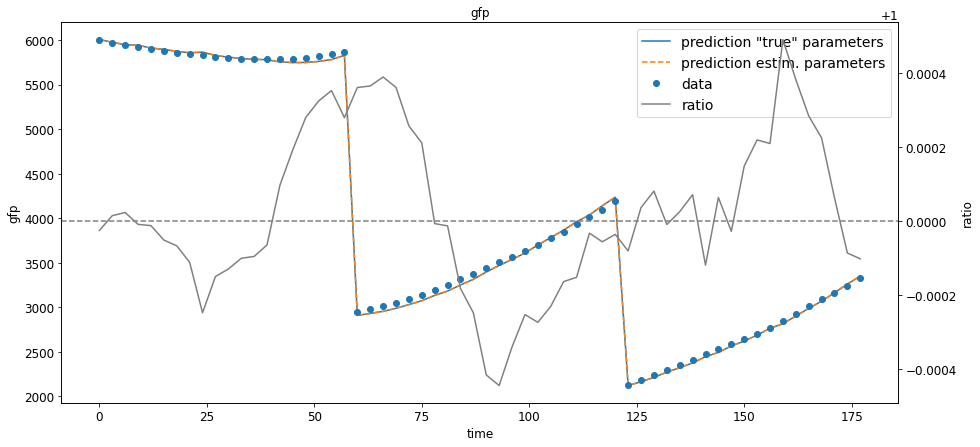

In [15]:
compare_predictios([data_prediction_no_min, data_prediction], ['prediction "true" params', 'prediction estim. params'], 'mean_x', data_dat, 'log_leng_no_noise',data_slice, "log length", ratio=(0,1))
compare_predictios([data_prediction_no_min, data_prediction], ['prediction "true" parameters', 'prediction estim. parameters'], 'mean_g', data_dat, 'gfp_no_noise',data_slice, "gfp", ratio=(0,1))


##  Total error and correlation

In [16]:
def total_sqerror(data1, data2):
    return np.sum(np.power(data1 - data2, 2))

def plot_corr_err(predictions, data, predictions_col, data_col, labels):
    comp = pd.DataFrame({"total_sq_error": [total_sqerror(p[predictions_col].to_numpy(), data[data_col].to_numpy()) for p in predictions ],
    "correlation": [np.corrcoef(p[predictions_col].to_numpy(), data[data_col].to_numpy())[0,1] for p in predictions]}, index=labels)
    axes = comp.plot.bar(rot=0, subplots=True)
    axes[0].legend(loc=3)
    axes[1].legend(loc=3)

    for i, r in enumerate(comp['total_sq_error']):
        axes[0].text(i -0.4, r*1.15 , "{:.2E}".format(r), va='center')
    for i, r in enumerate(comp['correlation']):
        axes[1].text(i -0.25, r*1.15 , "{:.3f}".format(r), va='center')
    axes[0].set_ylim([0, np.max(comp['total_sq_error']) *1.3 ])
    axes[1].set_ylim([0, np.max(comp['correlation'])*1.3 ])


### Log length

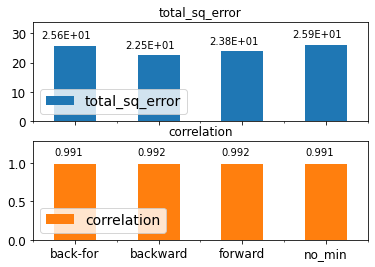

In [17]:
plot_corr_err([data_prediction, data_backward, data_forward, data_prediction_no_min], data_dat, 'mean_x', 'log_leng', ['back-for', 'backward', 'forward', 'no_min'])

### Gfp

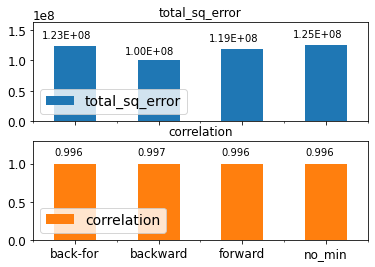

In [18]:
plot_corr_err([data_prediction, data_backward, data_forward, data_prediction_no_min], data_dat, 'mean_g', 'gfp_noise', ['back-for', 'backward', 'forward', 'no_min'])
